In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import os


# ResNet18을 위해 최대한 간단히 수정한 BasicBlock 클래스
class BasicBlock(nn.Module):
    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()

        # 3x3 필터를 사용 (너비와 높이를 줄일 때는 stride 값 조절)
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes) # 배치 정규화(batch normalization)

        # 3x3 필터를 사용 (패딩을 1만큼 주기 때문에 너비와 높이가 동일)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes) # 배치 정규화(batch normalization)

        self.shortcut = nn.Sequential() # identity인 경우
        if stride != 1: # stride가 1이 아니라면, identity mapping이 아닌 경우
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x) # (핵심) skip connection
        out = F.relu(out)
        return out


# ResNet 클래스 정의
class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super(ResNet, self).__init__()
        self.in_planes = 64

        # 64개의 3x3 필터(filter)를 사용
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        self.linear = nn.Linear(512, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1] * (num_blocks - 1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes # 다음 레이어를 위해 채널 수 변경
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out) # 출력: [batch_size, 512, 4, 4]
        out = F.avg_pool2d(out, 4) # 출력: [batch_size, 512, 1, 1]
        out = out.view(out.size(0), -1) # 출력: [batch_size, 512]
        out = self.linear(out)
        return out


# ResNet18 함수 정의
def ResNet18():
    return ResNet(BasicBlock, [2, 2, 2, 2])
# ResNet34 함수 정의
def ResNet34():
    return ResNet(BasicBlock, [3, 4, 6, 3])

In [ ]:
import matplotlib.pyplot as plt
import os
import numpy as np
import keras
from keras.models import Sequential
from keras.layers import Dense, Activation
# from data_utils import *
import tensorflow_datasets as tfds
%matplotlib inline
plt.rcParams['figure.figsize']=(10.0,8.0)
plt.rcParams['image.interpolation']='nearest'
plt.rcParams['image.cmap']='gray'

import tensorflow as tf
from keras import backend as k
import os

%load_ext autoreload
%autoreload 2

In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms

# Define transformations for training and testing/validation
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),  # Rotate randomly within the range of -15 to 15 degrees
    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),  # Adjust brightness, contrast, saturation, and hue
    transforms.ToTensor(),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
])

# Load CIFAR-10 dataset
train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)

# Split the training dataset into training and validation sets
# You can adjust the split ratio as needed
train_size = int(0.8 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(train_dataset, [train_size, val_size])

# Create data loaders for training, validation, and testing sets
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=128, shuffle=True, num_workers=2)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=128, shuffle=False, num_workers=2)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=128, shuffle=False, num_workers=2)


100%|██████████| 170498071/170498071 [00:03<00:00, 49261569.15it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [ ]:
import numpy as np

mixup_alpha = 1.0

def mixup_data(x, y):
    lam = np.random.beta(mixup_alpha, mixup_alpha) # assign the lamda value by beta distribution
    batch_size = x.size()[0]
    index = torch.randperm(batch_size).cuda()
    mixed_x = lam * x + (1 - lam) * x[index]
    y_a, y_b = y, y[index]
    return mixed_x, y_a, y_b, lam


def mixup_criterion(criterion, pred, y_a, y_b, lam):
    return lam * criterion(pred, y_a) + (1 - lam) * criterion(pred, y_b)


class LabelSmoothingCrossEntropy(nn.Module):
    def __init__(self):
        super(LabelSmoothingCrossEntropy, self).__init__()
    def forward(self, y, targets, smoothing=0.1):
        confidence = 1. - smoothing
        log_probs = F.log_softmax(y, dim=-1) # 예측 확률 계산
        true_probs = torch.zeros_like(log_probs)
        true_probs.fill_(smoothing / (y.shape[1] - 1))
        true_probs.scatter_(1, targets.data.unsqueeze(1), confidence) # 정답 인덱스의 정답 확률을 confidence로 변경
        return torch.mean(torch.sum(true_probs * -log_probs, dim=-1)) # negative log likelihood

In [ ]:
import time


def adjust_learning_rate(optimizer, epoch):
    lr = learning_rate
    if epoch >= 50:
        lr /= 10
    if epoch >= 100:
        lr /= 10
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr


In [ ]:
!pip install calflops
!pip install calflops-*-py3-none-any.whl

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 290.1/290.1 kB 8.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 40.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 37.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 39.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 2.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 2.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 7.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 8.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.2/124.2 MB 7.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.0/196.0 MB 2.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 166.0/166.0 MB 7.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.1/99.1 kB 15.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━


[ Epoch: 0 ]


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Train Loss: 0.018 | Train Acc: 20.285%
Val Loss: 0.016 | Val Acc: 30.580%

[ Epoch: 1 ]
Train Loss: 0.016 | Train Acc: 28.233%
Val Loss: 0.017 | Val Acc: 27.880%

[ Epoch: 2 ]
Train Loss: 0.016 | Train Acc: 33.011%
Val Loss: 0.014 | Val Acc: 44.450%

[ Epoch: 3 ]
Train Loss: 0.015 | Train Acc: 36.501%
Val Loss: 0.017 | Val Acc: 27.060%

[ Epoch: 4 ]
Train Loss: 0.015 | Train Acc: 38.612%
Val Loss: 0.013 | Val Acc: 53.530%

[ Epoch: 5 ]
Train Loss: 0.014 | Train Acc: 43.773%
Val Loss: 0.012 | Val Acc: 55.680%

[ Epoch: 6 ]
Train Loss: 0.014 | Train Acc: 44.744%
Val Loss: 0.012 | Val Acc: 57.420%

[ Epoch: 7 ]
Train Loss: 0.014 | Train Acc: 46.969%
Val Loss: 0.011 | Val Acc: 60.960%

[ Epoch: 8 ]
Train Loss: 0.013 | Train Acc: 50.063%
Val Loss: 0.012 | Val Acc: 58.970%

[ Epoch: 9 ]
Train Loss: 0.013 | Train Acc: 50.260%
Val Loss: 0.011 | Val Acc: 60.750%

[ Epoch: 10 ]
Train Loss: 0.013 | Train Acc: 52.267%
Val Loss: 0.011 | Val Acc: 65.270%

[ Epoch: 11 ]
Train Loss: 0.013 | Train Acc:

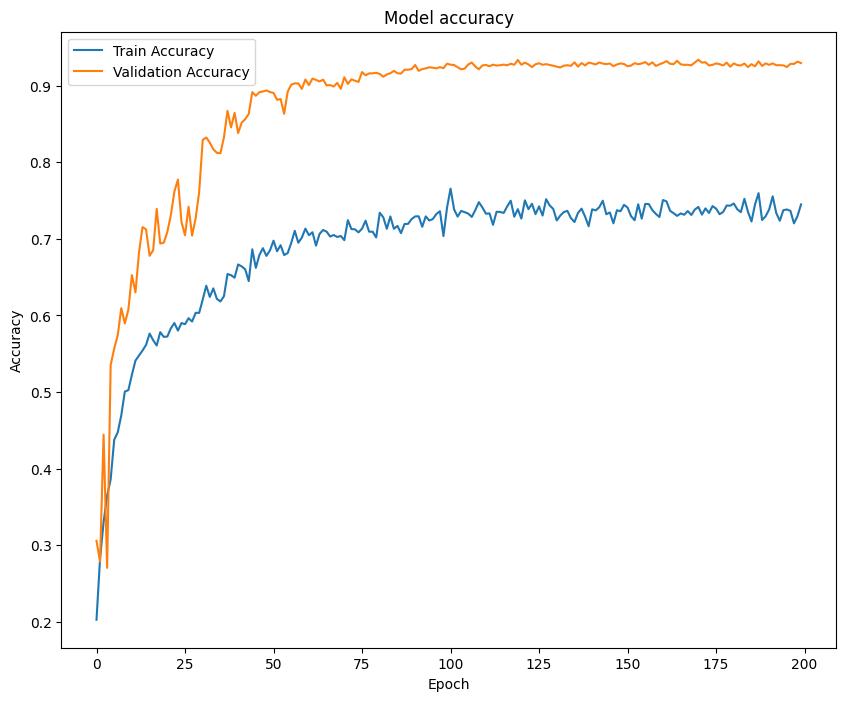

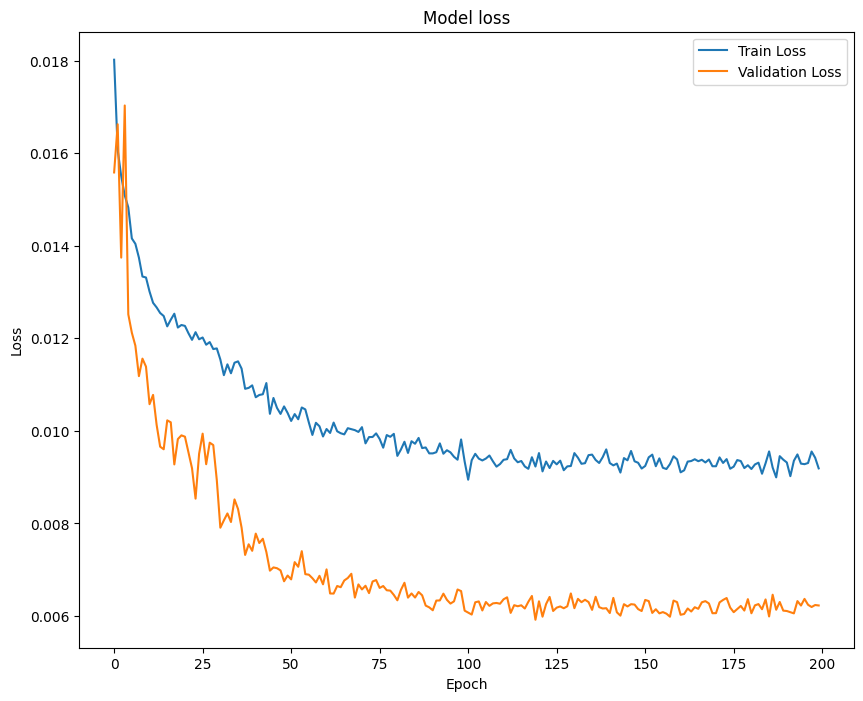

Test Loss: 0.006 | Test Acc: 94.180%


In [ ]:
# @title 기본 제목 텍스트
import torch
import torch.nn as nn
import torch.optim as optim
import os
import time
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt

from torch.optim.lr_scheduler import ReduceLROnPlateau
from sklearn import datasets
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader


# Assuming you have defined your ResNet18, mixup functions, and other necessary components already.

# Split the dataset into training and validation

device = 'cuda'

net = ResNet18()
net = net.to(device)

file_name = 'resnet18_cifar10.pth'
# Define the optimizer and loss function
learning_rate = 0.1
criterion = LabelSmoothingCrossEntropy()
optimizer = optim.SGD(net.parameters(), lr=learning_rate, momentum=0.9, weight_decay=5e-4)

# Define the number of epochs
EPOCHS = 200
# Define callbacks
reduceLR = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer,mode='min',patience=5,factor=0.5,min_lr=1e-6,verbose=True)
# earlystopping = torch.optim.lr_scheduler.EarlyStopping(patience=10, verbose=False, delta=0)

# Define lists to store metrics
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

# Training loop
start_time = time.time()
for epoch in range(EPOCHS):
    print('\n[ Epoch: %d ]' % epoch)

    # Training
    net.train()
    train_loss = 0
    correct = 0
    total = 0
    for batch_idx, (inputs, targets) in enumerate(train_loader):
        inputs, targets = inputs.to(device), targets.to(device)
        inputs, targets_a, targets_b, lam = mixup_data(inputs, targets)
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = mixup_criterion(criterion, outputs, targets_a, targets_b, lam)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = outputs.max(1)
        total += targets.size(0)
        current_correct = (lam * predicted.eq(targets_a).sum().item() + (1 - lam) * predicted.eq(targets_b).sum().item())
        correct += current_correct

    train_loss /= len(train_loader.dataset)
    train_acc = correct / total
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)

    print('Train Loss: %.3f | Train Acc: %.3f%%' % (train_loss, train_acc * 100))

    # Validation
    net.eval()
    val_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, targets in val_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = net(inputs)
            loss = criterion(outputs, targets)
            val_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()

    val_loss /= len(val_loader.dataset)
    val_acc = correct / total
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)

    print('Val Loss: %.3f | Val Acc: %.3f%%' % (val_loss, val_acc * 100))

    # Callbacks
    reduceLR.step(val_loss)
    # earlystopping.step(val_loss)

    # if earlystopping.stop:
    #     print("Early stopping triggered.")
    #     break

print('\nTotal Time Elapsed:', time.time() - start_time)

# Plotting
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()

plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

net.eval()
test_loss = 0
correct = 0
total = 0
with torch.no_grad():
    for inputs, targets in test_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        outputs = net(inputs)
        loss = criterion(outputs, targets)
        test_loss += loss.item()
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()

test_loss /= len(test_loader.dataset)
test_acc = correct / total

print('Test Loss: %.3f | Test Acc: %.3f%%' % (test_loss, test_acc * 100))
batch_size = 128  # Setting the batch size
input_shape = (batch_size, 3, 32, 32)  # Assuming CIFAR-10 input shape


